In [1]:
import os
import json
import hoomd
import codecs

import numpy as np

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render

from polykit.generators.initial_conformations import grow_cubic

In [2]:
# Initialise HooMD on the CPU or GPU, based on availability
hoomd_device = build.get_hoomd_device()

HOOMD is running on the following GPU(s):
[0] NVIDIA A100-PCIE-40GB 108 SM_8.0 @ 1.41 GHz, 40339 MiB DRAM


In [3]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 24517


In [4]:
# Initialize empty simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [5]:
# Simulate a chromosome comprised of 15000 monomers, with number density 0.2
density = 0.2
chromosome_sizes = [15000]

In [6]:
# Initialize simulation with the appropriate box size 
number_of_monomers = sum(chromosome_sizes)
L = (number_of_monomers/density) ** (1/3.)

snapshot = build.get_simulation_box(box_length=L)

In [7]:
# Build random, dense initial conformations
monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(L-1))

In [8]:
# Populate snapshot with the generated chains
build.set_chains(snapshot, monomer_positions, chromosome_sizes, monomer_type_list=['A'])

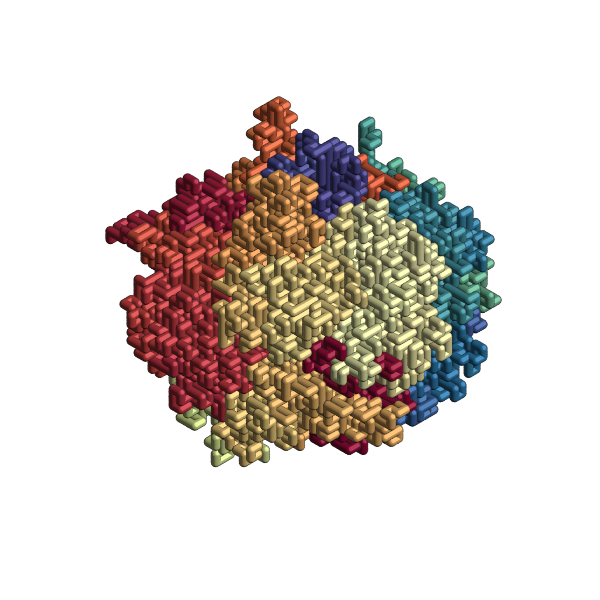

In [9]:
# Visualize starting conformation using the Fresnel backend
render.fresnel(snapshot, cmap="Spectral").static(pathtrace=False)

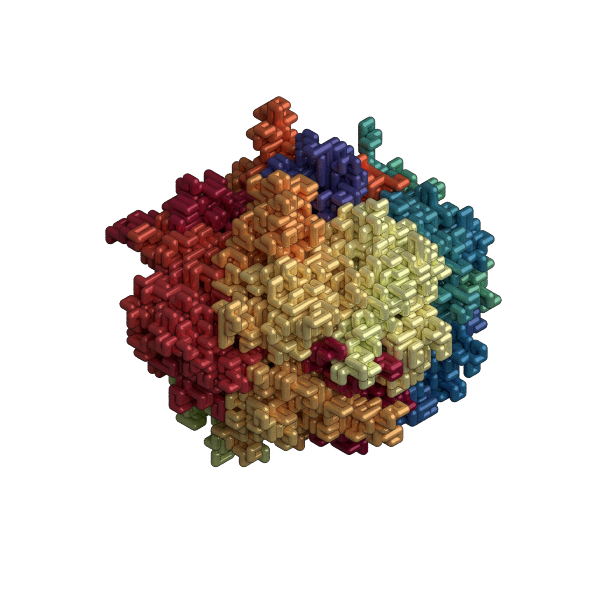

In [10]:
# Or go for fancy rendering using raycasting (slower!)
render.fresnel(snapshot, cmap="Spectral").static(pathtrace=True)

In [11]:
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

In [12]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.4)

In [13]:
# Read input force parameters
with open("force_dict_homopolymer.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

print(json.dumps(force_dict, indent=4, sort_keys=True))

{
    "Angular forces": {
        "Curvature": {
            "Stiffness": 1.5,
            "Type": "Harmonic"
        }
    },
    "Bonded forces": {
        "Backbone": {
            "Rest length": 1.0,
            "Type": "Harmonic",
            "Wiggle distance": 0.05
        }
    },
    "External forces": {
        "Confinement": {}
    },
    "Non-bonded forces": {
        "Repulsion": {
            "Cutoff": 1.0,
            "Matrix": {
                "A": {
                    "A": 3.0
                }
            },
            "Type": "Polychrom"
        }
    }
}


In [14]:
# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [15]:
# Set bonded/angular potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
angular_forces = forces.get_angular_forces(**force_dict)

In [16]:
# Define full force_field
force_field = repulsion_forces + bonded_forces + angular_forces

In [17]:
# HooMD to openMM time conversion factor
t_conv = (1.67377*10**-27/(1.380649*10**-23*300))**0.5

In [18]:
# Initialize integrators and Langevin thermostat
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
integrator = hoomd.md.Integrator(dt=70*t_conv, methods=[langevin], forces=force_field)

In [19]:
# Setup log and simulation engines
logger = log.get_logger(system)

system.operations.integrator = integrator
system.operations.writers.append(log.table_formatter(logger, period=1e4))

In [20]:
# Run
system.run(2e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       10000           5451.22384     0:00:34.854558           1.02793          
       20000           5976.14086     0:00:30.119772           1.01322          
       30000           6183.08519     0:00:27.494365           1.03775          
       40000           6295.80212     0:00:25.413759           1.03724          
       50000           6367.37617     0:00:23.557584           1.02444          
       60000           6412.08416     0:00:21.833775           1.01100          
       70000           6450.88695     0:00:20.152268           1.01587          
       80000           6478.93449     0:00:18.521564           1.01188          
       90000           6501.30674     0:00:16.919675           1.02586          
      100000           6516.00301     0:00:15.346831           1.01525          
      110000           6530.29351     0:00:13.781923           1.00921          
      120000           6542.

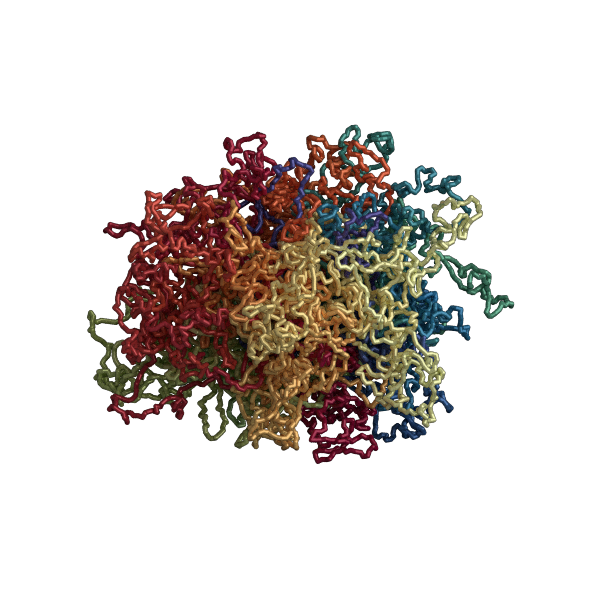

In [21]:
# Visualize new conformation
snapshot_relaxed = system.state.get_snapshot()
render.fresnel(snapshot_relaxed, cmap="Spectral").static(pathtrace=True)